<a href="https://colab.research.google.com/github/dave502/NLP/blob/main/lesson_06/nlp_hw_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install stop_words
!pip install eli5

In [42]:
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from tensorflow.keras import layers, losses 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from stop_words import get_stop_words
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import eli5
from tqdm.notebook import tqdm
from pathlib import Path
import pickle
from google.colab import drive
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('max_colwidth', 150)

In [3]:
%%capture
# получаем языковую модель spacy для русского языка
!python -m spacy download ru_core_news_md
# получаем стоп-слова
stopwords = set(get_stop_words("ru"))
# подключаем диск для сохранения промежуточных данных
drive.mount('/drive')

In [4]:
data_path = '/drive/My Drive/MLData/'
url = 'https://www.dropbox.com/s/or14swng92ea2y8/kinopoisk.jsonl?dl=1'

In [5]:
# скачивание файла данных
dataset = tf.keras.utils.get_file('kinopoisk.jsonl', url)

In [6]:
# чтение файла данных
df = pd.read_json(dataset, lines=True)
df.sample(5)

,part,movie_name,review_id,author,date,title,grade3,grade10,content
23012,top250,Гаттака (1997),26155,Sykina,2010-02-27,"«We are all in the gutter, but some of us are looking at the stars.».",Good,10.0,"\nКак же приятно находить вот такие вот фильмы для себя: глубокосмысленные, с идеей в основе сюжета, такие фильмы — от которых не можешь оторватьс..."
14338,top250,Совершенный мир (1993),24454,rainman.87,2009-10-01,None,Bad,0.0,"\nЭта картина, несомненно, одна из худших работ Клинта Иствуда. \n\nПреступника представляют как положительного персонажа, а мальчик, которого он ..."
33171,bottom100,Наша Маша и Волшебный орех (2009),25664,None,2009-12-19,None,Neutral,7.0,"\n Я не профессиональный критик, и вообще никогда не пишу рецензии к фильмам, но, прочитав довольно противоречивые отзывы к этой картине, реш..."
18297,top250,Остров проклятых (2009),9516,Daganet,2010-02-25,Хороший защитный механизм.,Good,0.0,"\nОн уже давно признан мастером и классиком. Его работы стали неким идеалом, образцом того как нужно снимать кино. Его имя в режиссерской графе го..."
34289,bottom100,Стритрейсеры (2008),25554,None,2011-06-05,Убого,Bad,0.0,"\n К 2008 году уже были сняты три Форсажа и четыре Такси, не говоря уже об Угнать за 60 секунд и других фильмов про гонки. Российские кинемат..."


In [7]:
# функция педобработки данных
# убираются сайты, символы, цифры, стоп-слова и токены с единичной длинной
def preprocessing(df:pd.DataFrame, columns:list=[])->pd.DataFrame:
  """
  функция обработки текста
  """  
  # регулярное выражение для очистки текста
  url_pattern = "(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
  onlywords_pattern = "[^\w\s]|[^A-Za-zА-ЯЁа-яё]"
  pattern = f"{url_pattern}|{onlywords_pattern}"

  prepr_df = df[columns].replace(pattern, ' ', regex=True)
  prepr_df.columns = ['prepr_'+colname for colname in columns]
  df = pd.concat([df, prepr_df], axis=1)

  # лемматизация, удаление стоп-слов и запись результата в новую колонку
  # morpher = MorphAnalyzer()
  # df['prepr_text'] = df['prepr_text'].apply(lambda x: [morpher.normal_forms(token)[0].strip().lower() for token in x.split()\
  #                                           if (token not in stopwords) and (len(token) > 2)])
  df['prepr_content'] = df['prepr_content'].apply(lambda x: " ".join([token for token in x.split() if (token not in stopwords) and (len(token) > 1)]))

  return df

In [8]:
%%time
# препроцессинг текста
df = preprocessing(df, ['content'])

CPU times: user 13.4 s, sys: 25.9 ms, total: 13.4 s
Wall time: 15.5 s


In [9]:
# инициализация spacy, проверка активных обработчиков
nlp = spacy.load('ru_core_news_md')
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [10]:
# с помощью spacy получаем лемматизированные данные и список именованных сущностей
lemma = []
ners = []
for doc in tqdm(nlp.pipe(df['prepr_content'].values, batch_size=500, n_process=-1)):
    ners.append({ent.text: ent.label_ for ent in doc.ents})
    lemma.append([n.lemma_ for n in doc])

0it [00:00, ?it/s]

In [12]:
df['spacy_lemma'] = lemma
df['spacy_pos'] = ners

In [25]:
df[['content', 'prepr_content', 'spacy_lemma', 'spacy_pos', 'grade3']].sample(10)

,content,prepr_content,spacy_lemma,spacy_pos,grade3
20702,\n40-е годы ХХ столетия. Этот период в мировой истории знаменателен прежде всего одним ужасным событием. Но в мире же кино данный временной период...,годы ХХ столетия Этот период мировой истории знаменателен прежде одним ужасным событием Но мире кино данный временной период несмотря общечеловече...,"[год, хх, столетие, этот, период, мировой, история, знаменательный, прежде, одним, ужасный, событие, но, мир, кино, данный, временной, период, нес...","{'Гражданин Кейн': 'PER', 'Ребекка Касабланка': 'PER', 'Третий мн др Но': 'PER', 'Кейна Касабланку': 'PER', 'Фрэнка Капры Эта': 'PER', 'Капра': 'P...",Good
16598,"\nДа-да, вас не подводит зрение, меня постигло именно разочарование.\n\nО «Начале» узнал месяцев за шесть до его просмотра, и с тех пор полностью ...",Да подводит зрение постигло разочарование Начале узнал месяцев просмотра полностью ограничил либо информации нём Так просмотра большого количества...,"[да, подводить, зрение, постичь, разочарование, начале, узнать, месяц, просмотр, полностью, ограничить, либо, информация, нём, так, просмотр, боль...","{'Начале': 'PER', 'Ажиотаж': 'PER', 'Ричарда Линклейтера Ведь': 'PER', 'Нолана': 'PER', 'Ничего': 'PER', 'Вместо': 'PER', 'Фильм': 'PER', 'Пушкинс...",Neutral
13402,"\nЗнаете, чем отличается советский кинематограф от современного российского? Тем, что 30—40 лет назад создавались шедевры на все времена, комедии,...",Знаете отличается советский кинематограф современного российского Тем создавались шедевры времена комедии надоест смотреть вышел таких фильмов ком...,"[знать, отличаться, советский, кинематограф, современный, российский, тем, создаваться, шедевр, времена, комедия, надоесть, смотреть, выйти, такой...","{'Тем': 'LOC', 'Леонида Гайдая': 'PER', 'Иван Васильевич': 'PER', 'Бунша Милославский': 'PER', 'Танцуют Всё': 'PER', 'Положь': 'PER', 'Задавлю': '...",Good
6657,"\nФильм показывает, что далеко не все такое, каким кажется на первый взгляд. Еще он учит не отступать, не поддаваться давлению. Я сама терпеть не ...",Фильм показывает каким взгляд Еще учит отступать поддаваться давлению терпеть могу спорить промолчу пойду конфликт плане поучиться главного героя ...,"[фильм, показывать, какой, взгляд, еще, учить, отступать, поддаваться, давление, терпеть, мочь, спорить, промолчу, пойти, конфликт, план, поучитьс...",{'Ведь': 'PER'},Neutral
7219,"\nДовольно редко получаешь столь сильный восторг от просмотренного тобою фильма, при этом когда заранее ни о чем таком не предполагаешь, рассчитыв...",Довольно редко получаешь столь сильный восторг просмотренного фильма заранее таком предполагаешь рассчитывая увидеть нечто среднее Заложница фильм...,"[довольно, редко, получать, столь, сильный, восторг, просмотренного, фильм, заранее, такой, предполагать, рассчитывать, увидеть, нечто, средний, з...","{'Заложница': 'LOC', 'Фильм': 'PER', 'Необычайно': 'PER', 'Драматичность': 'PER', 'Экшн': 'PER', 'Актерская': 'PER', 'Сюжет': 'PER', 'Лайам Нисон'...",Good
2370,"\nВсе же парадокс: стоит человеку достигнуть сокровенной цели, как вместо бурного ликования и полного удовлетворения приходит некоторое разочарова...",Все парадокс стоит человеку достигнуть сокровенной цели вместо бурного ликования полного удовлетворения приходит некоторое разочарование подчеркив...,"[весь, парадокс, стоить, человек, достигнуть, сокровенный, цель, вместо, бурный, ликование, полный, удовлетворение, приходить, некоторый, разочаро...","{'Шона Пенна': 'PER', 'Кристофера МакКэндлесса': 'PER', 'Тайлера Дердена': 'PER', 'Эмилем Хиршем': 'PER', 'Кристофером': 'PER', 'Долгий': 'LOC', '...",Good
17398,"\nПри просмотре фильма возникло ощущение, будто смотришь записи из домашнего архива сумасшедшего — уж больно всё как-то надуманно, а порой даже ст...",При просмотре фильма возникло ощущение смотришь записи домашнего архива сумасшедшего больно надуманно порой страшновато Может описанная сценарии Э...,"[при, просмотр, фильм, возникнуть, ощущение, смотреть, запись, домашний,

In [ ]:
# по списку именованных сущностей производится замена слов в предобработанных данных

# в данном случае для каждой строки используется свой словарь замены, возможно
# правильнее  и проще было сдлеать общий словарь NER для всего датафрейма
def replace_by_dict(text, replace_dict):
  for word, ner in replace_dict.items():
      text = text.replace(word, ner)
  return text

replaced_text = []
for i, (_, data) in enumerate(df['prepr_content'].items()):
   replaced_text.append(replace_by_dict(data, df.iloc[i]['spacy_pos']))

df['content_ner'] = replaced_text

In [21]:
# проверка произведённых замен. 
df[['content_ner', 'spacy_pos']].sample(10)

,content_ner,spacy_pos
1283,Полнометражный мультфильм ORG относится проектам невероятно известны невероятно ожидаемы столь невероятно качественны Но обо порядку Анимационные ...,"{'WALL': 'ORG', 'Casey Cooper': 'ORG', 'Короля': 'LOC', 'ВАЛЛ': 'ORG', 'Ева': 'PER', 'Зато': 'PER', 'Итог': 'LOC'}"
7430,Когда детстве многие посмотрел фильм запомнилось имени PER появлялось желание посмотреть фильм повторно хотелось узнать тайну молчания ягнят PER с...,"{'Лектер Очень': 'PER', 'Скажу': 'PER', 'Джоди Фостер Клариссой': 'PER', 'Лектору': 'PER', 'Хочется': 'PER', 'Оскара': 'PER', 'Ганнибала': 'PER', ..."
16576,PERт культовых фильмах давным разжевано считается спойлерами LOC вроде хорошего тона комментариев PER Этот фильм степени оскорбляет твое сознание ...,"{'Наоборот': 'LOC', 'Достоевскому': 'PER', 'Воображариум': 'PER', 'Парнаса': 'PER', 'Тут': 'PER', 'Форт Боярда': 'PER', 'Эдит Пиаф Жизни': 'PER', ..."
25231,PER любимейших режиссёров современности Настоящий мастер дела совместные картины PER включая вышедший PER проклятых входят число моих любимейших ф...,"{'Мартин Скорсезе': 'PER', 'ДиКаприо': 'PER', 'Остров': 'PER', 'Отступники': 'PER', 'Оскар': 'PER', 'Таким звёздным составом картина': 'ORG', 'Нач..."
26959,Любовь властвовать людьми изменять написал бессмертный Гете На примере многочисленных персонажей фильма Реальная любовь можем полной мере убедится...,"{'Ведь': 'PER', 'Ричарда Кёртиса': 'PER', 'Реальной': 'PER', 'Кертис': 'PER', 'Роуэном Аткинсоном Робином Дрисколлом Беном Элтоном': 'PER', 'Бина'..."
7319,Что PER удивил Его Район воспринял положительно посмотрел Из LOC любовью взгляд нелепый фильм PER смотреть хотелось PER разочаровал Однако частнос...,"{'Пьер Морель': 'PER', 'Парижа': 'LOC', 'Поэтому Заложницу': 'PER', 'Морель': 'PER', 'Кинопоиска': 'LOC', 'Джеймс Борн': 'PER', 'Джеймса Бонда': '..."
9883,Фильм обещании стороны невероятной нечеловеческой чёрствости тупости первых кадров фраза нашей стране PER пребывание нежелательно представляет оче...,"{'Ваше': 'PER', 'Наворского': 'PER', 'Нью Йорке': 'LOC', 'Кстати': 'LOC', 'Диксона': 'PER', 'Было': 'PER', 'Валеру Николаева': 'PER', 'Милодрагови..."
14777,Из экранизированных историй любви одна самых лучших моему мнению самая лучшая PER фильм испытываю невероятные эмоции PER фильм снятый шикарной кни...,"{'Смотрела': 'PER', 'Шикарный': 'PER', 'Знаете': 'PER', 'Ты': 'PER', 'Остаюсь Почему': 'PER', 'Ну Ты': 'PER', 'Вывод Жизнь': 'PER'}"
29455,Как жалуемся судьбу считаем неудачниками завидуем успеху окружающих PER вгоняем какие рамки ограничения мечемся клетке прожигаем которое отведено ...,"{'Сами': 'PER', 'Фильм Внутри': 'PER', 'Рори Ши': 'PER', 'Рори': 'PER', 'Рори Майкл': 'PER', 'Майкл Вот': 'PER', 'Черт': 'PER', 'Глаза': 'LOC', 'Ц..."
29221,Единственным недостатком данного фильма считаю длительность часов Уж автор затянул недостатки заканчиваются Фильм добрый трогательный На душе стан...,"{'Сандра Баллок': 'PER', 'Почему': 'PER', 'Обычно': 'PER', 'Учителя': 'PER', 'Потом': 'PER', 'Смотрите': 'PER'}"


Видно, что именованные сущности определяются не всегда корректно. Если слово начинается с большой буквы - spacy определяет его как NER. Но если перевести все в нижний регистр, многие сущности будут пропущены

In [20]:
# сохранение результатов
pickle.dump(df, open(data_path + 'reviews.pickle', 'wb'))

In [5]:
df = pd.read_pickle(data_path + 'reviews.pickle')

In [6]:
# данные со списком лемм преобразуем в строку
df['spacy_lemma'] = df['spacy_lemma'].apply(lambda x: " ".join(x))

In [7]:
# класс модели классификации
class ReviewRating():
  def __init__(self, df_review, df_rating, test_size=0.2, random_state=42):
    # разбиение датасета
    self.X_train, self.X_test, y_train, y_test = train_test_split(df_review, df_rating, test_size=0.2, random_state=42)  
    # кодирование признаков
    self.label_encoder = LabelEncoder()
    self.y_train = self.label_encoder.fit_transform(y_train)
    self.y_test = self.label_encoder.transform(y_test)
    # список векторайзеров
    self._vectorizers = [CountVectorizer(), 
                        #  CountVectorizer(ngram_range=(2, 3), analyzer='word'),
                        #  CountVectorizer(ngram_range=(2, 4), max_features=20000, analyzer='char_wb'),
                         TfidfVectorizer(),
                        #  TfidfVectorizer(ngram_range=(2, 3), analyzer='word'),
                        #  TfidfVectorizer(ngram_range=(2, 4), max_features=20000, analyzer='char'),
                         ]
    # список классификаторов
    self._classifiers = [LogisticRegression(max_iter=1000), naive_bayes.MultinomialNB()]
    # выбранные 
    self.current_vectorizer = self._vectorizers[0]
    self.current_classifier = self._classifiers[0]

    self.preds = None

  # фит-предикт
  def predict(self):
    model = Pipeline([
      ('vectorizer', self.current_vectorizer),
      ('classifier', self.current_classifier)])
  
    model.fit(self.X_train, self.y_train)
    self.preds = model.predict(self.X_test)
    return self.preds

  # печать точности
  def print_accuracy(self):
    print('Test accuracy = {:.2%}'.format(accuracy_score(self.y_test, self.preds)))

  # печать самых влиятельных токенов
  def show_weights(self, top):
    return eli5.show_weights(self.current_classifier, vec=self.current_vectorizer, top=top)

  # поиск наилучшего сочетания векторайзера и классификатора
  def select_model_by_score(self, set_best_option=True):
    best_score = 0
    best_option = None
    # перебор всех сочетаний и поиск наилучшего сочетания с лучшей метрикой
    options = product(self._vectorizers, self._classifiers)
    for option in options:
      print(option) 
      model = Pipeline([
          ('vectorizer', option[0]),
          ('classifier', option[1])])
      model.fit(self.X_train, self.y_train)
      score = model.score(self.X_test, self.y_test)
      print(f'the score for {option} is {score}')
      if score > best_score:
        best_score = score
        best_option = option

    print(f'the best score is {best_score} with {best_option}') 
    if set_best_option: # обновляем классификатор и веторайзер класса
        self.current_vectorizer = best_option[0]
        self.current_classifier = best_option[1]

**Предикт и метрика для данных с заменёнными именованными сущностями**

In [26]:
review_rating_with_ners = ReviewRating(df['content_ner'], df['grade3'])
_ = review_rating_with_ners.predict()
review_rating_with_ners.print_accuracy()

Test accuracy = 79.51%


In [27]:
review_rating_with_ners.show_weights()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Предикт и метрика для лемматизированных данных**

In [28]:
review_rating_with_lemmas = ReviewRating(df['spacy_lemma'], df['grade3'])
_ = review_rating_with_lemmas.predict()
review_rating_with_lemmas.print_accuracy()

Test accuracy = 79.19%


In [29]:
review_rating_with_lemmas.show_weights()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Предикт и метрика для простого предобработанного текста**

In [50]:
review_rating_with_preprocessing = ReviewRating(df['prepr_content'], df['grade3'])
pred = review_rating_with_preprocessing.predict()
review_rating_with_preprocessing.print_accuracy()

Test accuracy = 80.04%


In [31]:
review_rating_with_preprocessing.show_weights()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим мартицу ошибок для последнего предикта

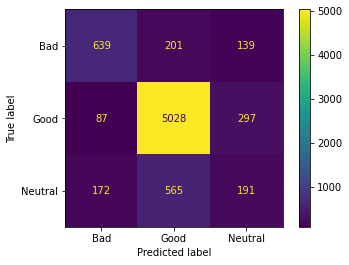

In [38]:
matrix = confusion_matrix(review_rating_with_preprocessing.y_test, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=review_rating_with_preprocessing.label_encoder.classes_) 
cm_display.plot()

По матрице ошибок видно, что подавляющее большинство нейтральных отзывов определилось как положительные. Что, естественно, плохо сказалось на общей точности модели. Проблему с нейтральными отзывами можно было предвидеть по топ нейтральным токенам. Многие из них очевидно не относятся к нейтральной семантике (кассету, разговоров, красива, красавчик и т.д.) и по хорошему, следует их отправить в стоп-слова и произвести анализ без них. Если бы это не заняло слишком много времени.
По отличиям в зависимости от обработки текста разница в точности небольшая. Небольшое преимущество у текста с простой предобработкой (удадение символов, цифр, токенов с единичной длинной). Несмотря на большую частотность заменённых NER (PER, ORG, LOC...), ни один оз них не попал в топ 20 токенов. Топы токенов для положительных и отрицательных отзывов определились хорошо

Проверка работы модели с разными классификаторами и векторайзерами

In [8]:
best_model = ReviewRating(df['prepr_content'], df['grade3']).select_model_by_score()

(CountVectorizer(), LogisticRegression(max_iter=1000))
the score for (CountVectorizer(), LogisticRegression(max_iter=1000)) is 0.8003825659243066
(CountVectorizer(), MultinomialNB())
the score for (CountVectorizer(), MultinomialNB()) is 0.8068042082251674
(TfidfVectorizer(), LogisticRegression(max_iter=1000))
the score for (TfidfVectorizer(), LogisticRegression(max_iter=1000)) is 0.8203306462631507
(TfidfVectorizer(), MultinomialNB())
the score for (TfidfVectorizer(), MultinomialNB()) is 0.7394452794097555
the best score is 0.8203306462631507 with (TfidfVectorizer(), LogisticRegression(max_iter=1000))


TfidfVectorizer в сочетании с логистической регрессией показал себя лучше каунт векторайзера. <br>
*К сожалению, н-граммные векторайзеры не получилось проверить из-за нехватки памяти у колаба*

**Проверка работы нейронной сети**

In [7]:
# инициализация энкодера меток в вектор вида [x,x,x] для многоклассовой классификации
from sklearn.preprocessing import MultiLabelBinarizer
label_one_hot = MultiLabelBinarizer()
label_one_hot.fit(df['grade3'].apply(lambda x: [x]))

MultiLabelBinarizer()

In [8]:
# метки распознались
print(label_one_hot.classes_)

['Bad' 'Good' 'Neutral']


In [9]:
# разбиение датасета
X_val_train, X_test, y_val_train, y_test = train_test_split(df['prepr_content'], df['grade3'], test_size=0.2, random_state=42)  
X_train, X_valid, y_train, y_valid = train_test_split(X_val_train, y_val_train, test_size=0.25, random_state=42) 

In [10]:
# энкодинг меток в вектор вида [x,x,x] для многоклассовой классификации
y_train = label_one_hot.transform(y_train.apply(lambda x: [x]))
y_valid = label_one_hot.transform(y_valid.apply(lambda x: [x]))
y_test = label_one_hot.transform(y_test.apply(lambda x: [x]))

In [11]:
# преобразование данных в тензоры, батчи тензоров и кеширование
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_data = tf.data.Dataset.from_tensor_slices(X_test)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.batch(16).cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.batch(16).cache().prefetch(buffer_size=AUTOTUNE)
test_data  = test_data.batch(16).cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# инициализация слоя векторизации текста
def custom_standardization(input_data):
    return input_data

vocab_size = 10000
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [30]:
# размер эмбеддингов
embedding_dim = 16

# чуть более сложные сетки чем несколько полносвязных слоёв быстро переобучаются

# model_lstm = tf.keras.Sequential([
#     vectorize_layer,
#     layers.Embedding(vocab_size + 1, embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
#     tf.keras.layers.Dense(8, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3)
# ])


In [72]:
# простая сетка для классификации на 3 класса
model = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(vocab_size + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)])


In [73]:
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [74]:
# обучение
epochs = 6
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs)

Epoch 1/6
1373/1373 [==============================] - 7s 5ms/step - loss: 0.7387 - accuracy: 0.7449 - val_loss: 0.6608 - val_accuracy: 0.7461
Epoch 2/6
1373/1373 [==============================] - 7s 5ms/step - loss: 0.5937 - accuracy: 0.7603 - val_loss: 0.5665 - val_accuracy: 0.7819
Epoch 3/6
1373/1373 [==============================] - 7s 5ms/step - loss: 0.5131 - accuracy: 0.8031 - val_loss: 0.5343 - val_accuracy: 0.7986
Epoch 4/6
1373/1373 [==============================] - 7s 5ms/step - loss: 0.4729 - accuracy: 0.8179 - val_loss: 0.5229 - val_accuracy: 0.8030
Epoch 5/6
1373/1373 [==============================] - 6s 5ms/step - loss: 0.4403 - accuracy: 0.8275 - val_loss: 0.5201 - val_accuracy: 0.8051
Epoch 6/6
1373/1373 [==============================] - 7s 5ms/step - loss: 0.4132 - accuracy: 0.8377 - val_loss: 0.5219 - val_accuracy: 0.8105


In [75]:
# предикт
nn_pred = model.predict(test_data)

458/458 [==============================] - 2s 4ms/step


In [68]:
# преобразование результатов для подсчета метрики
max_pred = np.argmax(nn_pred, axis=1)
max_test = np.argmax(y_test, axis=1)

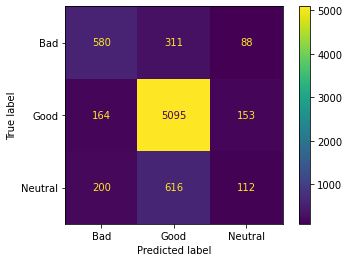

In [76]:
# матрица ошибок
nn_pred_max = np.argmax(nn_pred, axis=1)
matrix = confusion_matrix(max_test, max_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=label_one_hot.classes_) 
cm_display.plot()

По матрице видно, что результаты не лучше, чем у логистической регрессии. При этом, тенденция такая же - плохой предикт нейтральных отзывов

In [77]:
print('Test accuracy = {:.2%}'.format(accuracy_score(max_test, max_pred)))

Test accuracy = 79.07%


Метрика получилась не лучше, чем у классического классификатора. При этом от логистической регрессии можно добиться лучших результатов, экспериментируя с гиперпараметрами. Сетки с различными конфигурациями все были склонны к быстрому переобучению.